In [1]:
from src.utils import create_square, plot_function
from src.models.cell_models import ReparametrizedFitzHughNagumo
from src.models.dynamics_models import BidomainModel
import numpy as np
import ufl

### Solver workflow:
 1. Define a domain mesh - ``utils.create_mesh`` or ``utils.import_mesh`` can be used.\
 Then ``ufl.SpatialCoordinate(domain)`` can be defined if it will be used.

 2. Pick a cell model from cell_models module.

 3. Define a dynamics model class which inherits from one of dynamic modules from a dynamics_models module.\
 Define ``initial_V_m`` method for that class as it is requested in the description of the method.

 4. Run a ``solve`` method of a model with its parameters.

In [2]:
domain = create_square(32, 32)
x = ufl.SpatialCoordinate(domain)
cell_model = ReparametrizedFitzHughNagumo()


class Model(BidomainModel):
    def __init__(
        self,
    ):
        pass

    def initial_V_m(self):
        return lambda x: x[0] ** 2 + x[1] ** 2 < 0.2**2, 0.0

    def ischemia(self):
        return (
            (x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2 < 0.5**2,
            model.M_i / 10,
            model.M_e / 10,
        )


model = Model()
V, signal = model.solve(
    T=500,
    steps=500,
    domain=domain,
    cell_model=cell_model,
    gif_name="demo.gif",
    signal_point=[0.2, 0.2, 0.0],
)

Solving problem: 100%|██████████| 500/500 [00:51<00:00,  9.70it/s]


### Plotting a final plot of transmembrane potential

In [3]:
plot_function(V)

Widget(value='<iframe src="http://localhost:33045/index.html?ui=P_0x7f3313da2350_0&reconnect=auto" class="pyvi…

### Plotting a transmembrane potential in a given signal point

Text(0.5, 1.0, 'Time dependence of transmembrane potential')

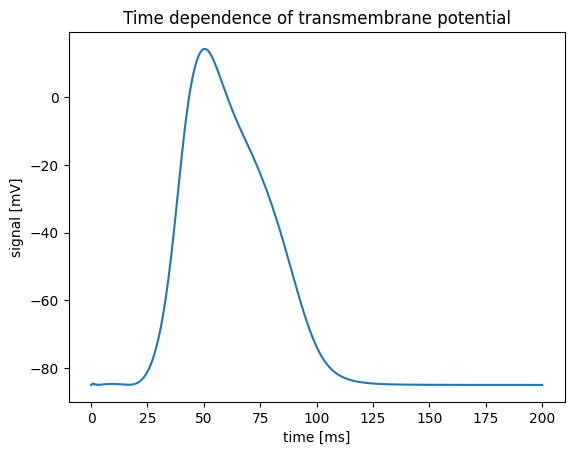

In [4]:
import matplotlib.pyplot as plt

time = np.linspace(0, 200, len(signal))
plt.plot(time, signal)
plt.xlabel("time [ms]")
plt.ylabel("signal [mV]")
plt.title("Time dependence of transmembrane potential")

### Plotting a transmembrane potential solution of a cell model

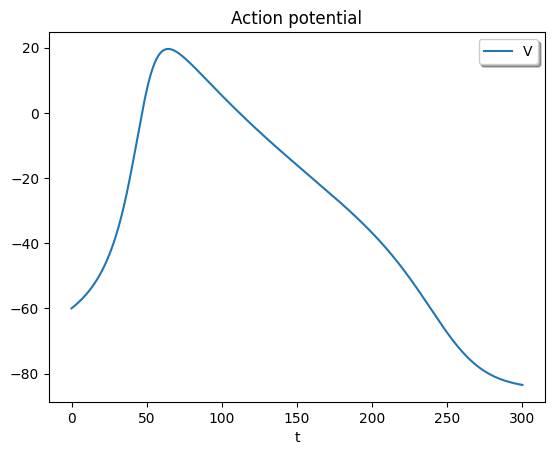

In [5]:
cell_model.visualize(300, -60, 0)